In [226]:
import numpy as np
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.data.Metrics import relRMSE
from ssapp.Utils import train_test_dataloader_split
from torch.utils.data.dataloader import DataLoader
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern
!nvidia-smi
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver('GaussianProcessHyperParameterTuning')

/bin/bash: nvidia-smi: command not found
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
dataset = load_serialized_dataset('CircularHornDataset1_Train')

train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=0.7)

train_params, train_fields = next(iter(train_dataloader))
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))

kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")

std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])

def score(model,x,y):
    pred = model.predict(x)
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))



In [223]:
length_scale_sweep = np.linspace(0.1,10,90)

train_loss = []
val_loss = []

for length_scale in length_scale_sweep:
    kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(length_scale, length_scale_bounds="fixed")

    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


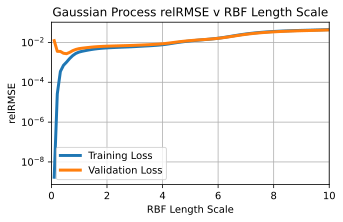

In [225]:
plt.figure(figsize = (5,3))
plt.plot(length_scale_sweep,train_loss,label = 'Training Loss',linewidth = 3)
plt.plot(length_scale_sweep,val_loss,label = 'Validation Loss',linewidth = 3)
#plt.xscale('log')
plt.yscale('log')
plt.xlim([0,max(length_scale_sweep)])
plt.grid()
plt.title('Gaussian Process relRMSE v RBF Length Scale')
plt.xlabel('RBF Length Scale')
plt.ylabel('relRMSE')

plt.legend()
best_val = length_scale_sweep[val_loss == min(val_loss)]

figSaver.save(filename = 'ValidationErrorContourPlot')

array([1.])

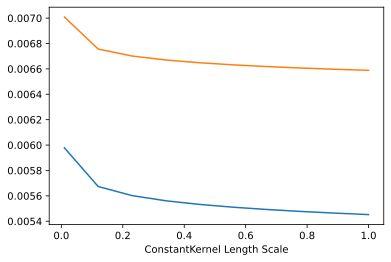

In [222]:
ConstVals = np.linspace(0.01,1,10)


train_loss = []
val_loss = []

for ConstVal in ConstVals:
    kernel = ConstantKernel(ConstVal, constant_value_bounds="fixed") * RBF(2.10224719, length_scale_bounds="fixed")

    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))

plt.figure()
plt.plot(ConstVals,train_loss,label = 'Training Loss')
plt.plot(ConstVals,val_loss,label = 'Validation Loss')
plt.xlabel('ConstantKernel Length Scale')
ConstVals[val_loss == min(val_loss)]

In [75]:
from matplotlib.colors import LogNorm
train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=0.07)
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))



gp =  GaussianProcessRegressor(kernel = kernel, normalize_y=True)

dims = (10,10)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
const_scales = np.logspace(0.01, 1.1, num=dims[0], base=10)-1
RBF_scales = np.logspace(0.01,  1.1, num=dims[1], base=10)-1
const_scales, RBF_scales = np.meshgrid(const_scales, RBF_scales)


score_grid = np.array([])

for const_scale,RBF_scale in zip(const_scales.flatten(),RBF_scales.flatten()):

    
    kernel = ConstantKernel(const_scale, constant_value_bounds="fixed") * RBF(RBF_scale,length_scale_bounds="fixed")
    gp =  GaussianProcessRegressor(kernel = kernel, normalize_y=True)

    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Const:{const_scale}, Length Scale: {RBF_scale}, Score: {iter_score}')

score_grid = score_grid.reshape(dims)

Const:0.0232929922807541, Length Scale: 0.0232929922807541, Score: 0.6795241534449357
Const:0.35241852546266106, Length Scale: 0.0232929922807541, Score: 0.6795241425704381
Const:0.787401928687085, Length Scale: 0.0232929922807541, Score: 0.6795241421452802
Const:1.3622906626344617, Length Scale: 0.0232929922807541, Score: 0.6795241419999182
Const:2.1220829994678336, Length Scale: 0.0232929922807541, Score: 0.6795241419286344
Const:3.126250173082264, Length Scale: 0.0232929922807541, Score: 0.6795241418875808
Const:4.453391371646277, Length Scale: 0.0232929922807541, Score: 0.6795241418617258
Const:6.207385932717452, Length Scale: 0.0232929922807541, Score: 0.6795241418445181
Const:8.52552429176778, Length Scale: 0.0232929922807541, Score: 0.6795241418326371
Const:11.589254117941675, Length Scale: 0.0232929922807541, Score: 0.679524141824226
Const:0.0232929922807541, Length Scale: 0.35241852546266106, Score: 0.005393549214809695
Const:0.35241852546266106, Length Scale: 0.35241852546266

0.505321988427605


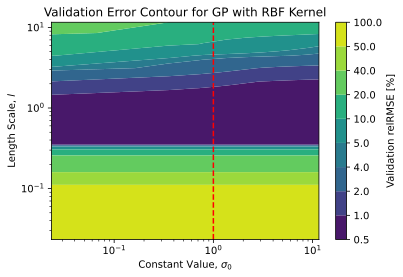

<Figure size 432x288 with 0 Axes>

In [219]:
from matplotlib import ticker, cm
from ssapp.Utils import FigureSaver



fig,ax=plt.subplots(1,1)
print(score_grid.min()+0.5)
norm = cm.colors.Normalize(vmax=abs(score_grid).max(), vmin=-abs(score_grid).max())

cp = ax.contourf(const_scales,RBF_scales,score_grid*100,levels = 20,locator=ticker.LogLocator(subs = [0.5,1,2,4]))
cb = fig.colorbar(cp)
cb.set_label('Validation relRMSE [%]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(1,c='r',linestyle = '--')
ax.set_xlabel("Constant Value, $\sigma_0$")
ax.set_ylabel("Length Scale, $l$")
ax.set_title("Validation Error Contour for GP with RBF Kernel")
plt.show()
figSaver.save(filename = 'ValidationErrorContourPlot')

In [229]:


from matplotlib.colors import LogNorm
train_dataloader, val_dataloader = train_test_dataloader_split(dataset,batch_size = None,TRAIN_TEST_RATIO=0.07)
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))



gp =  GaussianProcessRegressor(kernel = kernel, normalize_y=True)

dims = (2,2)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
length_scales = np.logspace(0.01, 1.1, num=dims[0], base=10)-1
Nu_scales = np.logspace(0.01,  1.1, num=dims[1], base=10)-1
length_scales, Nu_scales = np.meshgrid(length_scales, Nu_scales)


score_grid = np.array([])

for length_scale,Nu_scale in zip(length_scales.flatten(),Nu_scales.flatten()):

    
    kernel = ConstantKernel(1, constant_value_bounds="fixed") * Matern(length_scale=1,length_scale_bounds='fixed',nu=4)

    gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Const:{const_scale}, Length Scale: {RBF_scale}, Score: {iter_score}')

score_grid = score_grid.reshape(dims)

0.0011559485269877082
